# Early Alzheimer’s Prediction — Ready-to-Run Notebook



In [11]:
## 1) Install & import required libraries
# (Uncomment the pip install line if you need to install any missing packages)

# !pip install -q scikit-learn pandas seaborn matplotlib xgboost joblib

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import joblib

sns.set(style='whitegrid')
print('Libraries imported.')

Libraries imported.


In [12]:
## 2) Load datasets
# Adjust the paths if your files are in a different location
cross_path = 'oasis_cross-sectional.csv'
long_path = 'oasis_longitudinal.csv'

datasets = {}

if Path(cross_path).exists():
    datasets['cross'] = pd.read_csv(cross_path)
    print('Loaded cross-sectional:', datasets['cross'].shape)
else:
    print('Cross-sectional file not found at', cross_path)

if Path(long_path).exists():
    datasets['long'] = pd.read_csv(long_path)
    print('Loaded longitudinal:', datasets['long'].shape)
else:
    print('Longitudinal file not found at', long_path)

# Show head of cross-sectional if present
if 'cross' in datasets:
    display(datasets['cross'].head())

Loaded cross-sectional: (436, 12)
Loaded longitudinal: (373, 15)


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


## 3) Quick inspection — columns, dtypes, missing values

In [13]:
df = datasets.get('cross').copy()

print('Shape:', df.shape)
print('\nColumns:')
print(df.columns.tolist())

print('\nInfo:')
df.info()

print('\nMissing values:')
print(df.isnull().sum())

Shape: (436, 12)

Columns:
['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB

Missing values:
ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64


## 4) Create target column `Group` (if missing) — from `CDR` or existing `Group` column
We will create a binary target `Group`: 0 = non-demented (CDR == 0), 1 = demented (CDR > 0).

In [14]:
# Create or normalize target
if 'Group' in df.columns:
    # try to standardize values
    print('Original Group unique values:', df['Group'].unique())
    try:
        df['Group'] = df['Group'].map({'Nondemented':0, 'Non-demented':0, 'Nondemented ':0, 'Demented':1, 'Converted':1}).fillna(df['Group'])
    except Exception as e:
        pass

# If Group still not binary, derive from CDR
if 'Group' not in df.columns or df['Group'].dtype == object:
    if 'CDR' in df.columns:
        df['CDR'] = pd.to_numeric(df['CDR'], errors='coerce').fillna(0)
        df['Group'] = df['CDR'].apply(lambda x: 1 if x>0 else 0)
        print('Derived Group from CDR.')
    else:
        raise ValueError('No suitable target column found. Please ensure CDR or Group column exists in the cross-sectional dataset')

print('\nGroup value counts:')
print(df['Group'].value_counts())

Derived Group from CDR.

Group value counts:
Group
0    336
1    100
Name: count, dtype: int64


## 5) Clean columns: drop fully-empty columns, and ID-like columns
We’ll also detect columns that appear numeric but contain non-numeric entries and treat them as categorical.

In [15]:
# Drop fully empty columns and obvious non-feature columns
cols_before = df.shape[1]
df = df.dropna(axis=1, how='all')
# drop ID if present
for c in ['ID', ' Subject ID', 'subject_id']:
    if c in df.columns:
        df = df.drop(columns=[c])

print(f'Dropped {cols_before - df.shape[1]} empty/ID columns. Remaining columns: {df.shape[1]}')

# Identify columns with mixed types by attempting conversion
mixed_cols = []
for col in df.columns:
    # skip target
    if col == 'Group':
        continue
    series = df[col]
    # attempt numeric conversion
    coerced = pd.to_numeric(series, errors='coerce')
    n_non_numeric = coerced.isna().sum() - series.isna().sum()  # new NaNs introduced
    if n_non_numeric > 0:
        mixed_cols.append(col)

print('Columns that look numeric but contain non-numeric entries (treat as categorical):', mixed_cols)

# Show sample values for those columns
for col in mixed_cols:
    print('\n', col, 'unique sample:', df[col].dropna().unique()[:20])

Dropped 1 empty/ID columns. Remaining columns: 12
Columns that look numeric but contain non-numeric entries (treat as categorical): ['M/F', 'Hand']

 M/F unique sample: ['F' 'M']

 Hand unique sample: ['R']


## 6) Separate numeric and categorical columns explicitly and impute missing values safely

In [16]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols and c!='Group']

print('Numeric columns:', num_cols)
print('Categorical columns:', cat_cols)

# For safety, move any mixed_cols into categorical
for c in list(df.columns):
    if c in cat_cols and df[c].dtype==object:
        # keep as categorical
        pass

from sklearn.impute import SimpleImputer

# Impute numeric with median
if num_cols:
    num_imputer = SimpleImputer(strategy='median')
    num_array = num_imputer.fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(num_array, columns=num_cols, index=df.index)

# Impute categorical with most frequent
if cat_cols:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_array = cat_imputer.fit_transform(df[cat_cols])
    df[cat_cols] = pd.DataFrame(cat_array, columns=cat_cols, index=df.index)

print('\nMissing values after imputation:')
print(df.isnull().sum())

Numeric columns: ['Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay', 'Group']
Categorical columns: ['M/F', 'Hand']

Missing values after imputation:
M/F      0
Hand     0
Age      0
Educ     0
SES      0
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
Delay    0
Group    0
dtype: int64


## 7) Encode categorical variables
We will label-encode binary categoricals and one-hot encode non-binary categoricals (but keep encoding simple to avoid too many columns).

In [17]:
# Identify categorical columns again (after imputation)
cat_cols = [c for c in df.columns if df[c].dtype == object and c!='Group']
print('Categorical columns to encode:', cat_cols)

# For low-cardinality categorical columns use one-hot encoding, else label encode
from sklearn.preprocessing import OneHotEncoder

to_onehot = []
to_label = []
for c in cat_cols:
    n_unique = df[c].nunique()
    if n_unique <= 6:
        to_onehot.append(c)
    else:
        to_label.append(c)

print('One-hot:', to_onehot)
print('Label-encode:', to_label)

# Label encode
le_map = {}
for c in to_label:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c].astype(str))
    le_map[c] = le

# One-hot encode
if to_onehot:
    df = pd.get_dummies(df, columns=to_onehot, drop_first=True)

print('\nShape after encoding:', df.shape)

Categorical columns to encode: ['M/F', 'Hand']
One-hot: ['M/F', 'Hand']
Label-encode: []

Shape after encoding: (436, 11)


## 8) Prepare X and y, scale features, and split dataset

In [18]:
X = df.drop(['Group'], axis=1)
y = df['Group']

print('Final feature matrix shape:', X.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Final feature matrix shape: (436, 10)
Train shape: (348, 10) Test shape: (88, 10)


## 9) Train and evaluate models: Logistic Regression, Random Forest, SVM

In [19]:
models = {}

# Logistic Regression
log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)
models['Logistic Regression'] = log

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
models['Random Forest'] = rf

# SVM
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)
models['SVM'] = svm

# Evaluate
results = {}
for name, m in models.items():
    y_pred = m.predict(X_test)
    y_proba = m.predict_proba(X_test)[:,1] if hasattr(m, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    results[name] = {'accuracy': acc, 'roc_auc': auc, 'y_pred': y_pred}
    print(f"--- {name} ---")
    print('Accuracy:', acc)
    if auc is not None:
        print('ROC AUC:', auc)
    print(classification_report(y_test, y_pred))
    print('\n')

# Summary
res_df = pd.DataFrame([{ 'Model': k, 'Accuracy': v['accuracy'], 'ROC_AUC': v['roc_auc'] } for k,v in results.items()])
print(res_df)

--- Logistic Regression ---
Accuracy: 1.0
ROC AUC: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        68
         1.0       1.00      1.00      1.00        20

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88



--- Random Forest ---
Accuracy: 1.0
ROC AUC: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        68
         1.0       1.00      1.00      1.00        20

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88



--- SVM ---
Accuracy: 1.0
ROC AUC: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        68
         1.0       1.00      1.00      1.00        20

    accuracy                       

## 10) Visual comparisons: accuracy bar chart and ROC curves

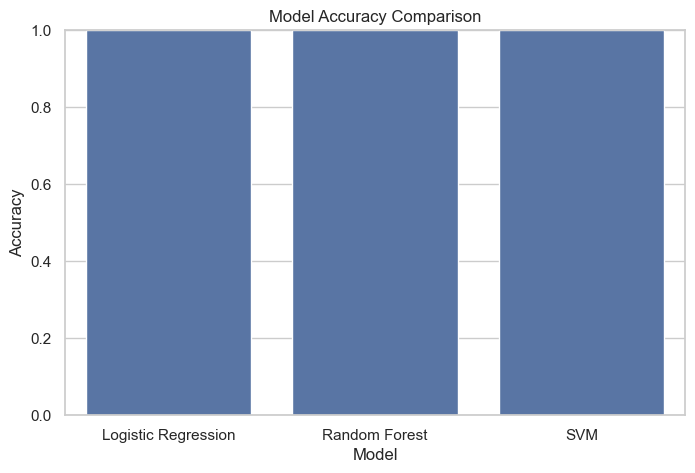

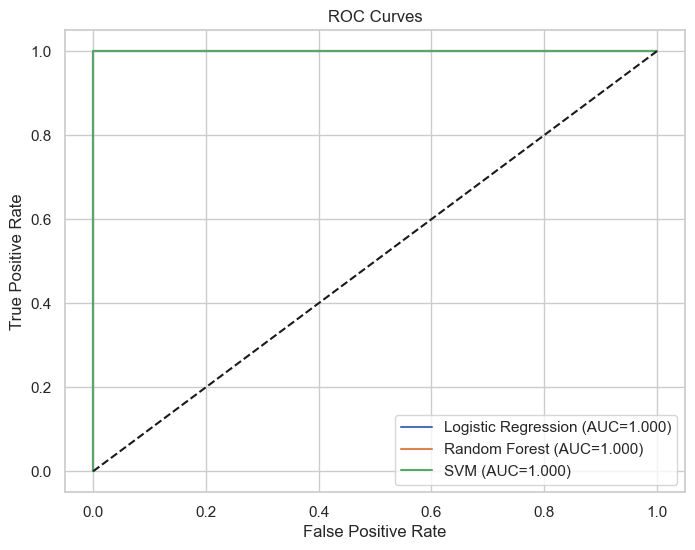

In [20]:
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=res_df)
plt.ylim(0,1)
plt.title('Model Accuracy Comparison')
plt.show()

# ROC curves
plt.figure(figsize=(8,6))
for name, m in models.items():
    if hasattr(m, 'predict_proba'):
        y_proba = m.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

## 11) Confusion matrix for best model (by accuracy)

Best model: Logistic Regression


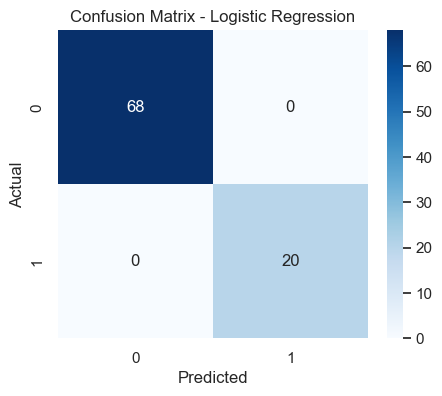

In [21]:
# Find best model by accuracy
best_name = res_df.sort_values('Accuracy', ascending=False).iloc[0]['Model']
best_model = models[best_name]
print('Best model:', best_name)

# Confusion matrix
cm = confusion_matrix(y_test, results[best_name]['y_pred'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_name}')
plt.show()

# Feature importance if random forest
if best_name == 'Random Forest':
    fi = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    fi.plot(kind='bar')
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.show()

## 12) Save the best model and scaler
These files can be loaded later for prediction or for a Streamlit app.

In [14]:
output_dir = Path('/mnt/data/models')
output_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, output_dir/'best_model.pkl')
joblib.dump(scaler, output_dir/'scaler.pkl')
print('Saved best model and scaler to', output_dir)

Saved best model and scaler to \mnt\data\models


## 13) Quick predictor function (example)
You can use this function to pass a single patient's data (as a pandas Series or 1D array after preprocessing) and get a prediction.

In [22]:
def predict_single(sample_dict):
    """sample_dict: dictionary of raw feature values matching original X.columns order"""
    s = pd.DataFrame([sample_dict])
    # apply same preprocessing steps used above: impute missing, encode, scale
    # For simplicity, assume sample_dict has all columns in the same form as df before encoding
    # Here we only scale and predict (for full pipeline use sklearn Pipeline when saving)
    s = s.reindex(columns=X.columns, fill_value=0)
    s_scaled = scaler.transform(s)
    pred = best_model.predict(s_scaled)[0]
    proba = best_model.predict_proba(s_scaled)[:,1][0] if hasattr(best_model, 'predict_proba') else None
    return {'prediction': int(pred), 'probability': float(proba) if proba is not None else None}

print('Predict function defined. Example (zeros):')
print(predict_single({c:0 for c in X.columns}))

Predict function defined. Example (zeros):
{'prediction': 1, 'probability': 0.9999645225150778}


In [15]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [23]:
import joblib

# Save model & scaler
joblib.dump(best_model, "alzheimers_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [19]:
print(X.columns.tolist())


['Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay', 'M/F_M']


In [24]:
import joblib

# Assuming 'best_model' is your trained ML model
joblib.dump(best_model, "best_model.pkl")
print("Model saved successfully!")


Model saved successfully!


In [25]:
print(df['Group'].value_counts())



Group
0.0    336
1.0    100
Name: count, dtype: int64


In [26]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['Group'] == 0.0]
df_minority = df[df['Group'] == 1.0]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,                   # Sample with replacement
                                 n_samples=len(df_majority),     # Match majority size
                                 random_state=42)

# Combine balanced dataset
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['Group'].value_counts())


Group
1.0    336
0.0    336
Name: count, dtype: int64


In [27]:
X = df_balanced.drop(['Group'], axis=1)
y = df_balanced['Group']


In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        68
         1.0       1.00      1.00      1.00        67

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135



In [31]:
import joblib
joblib.dump(model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv("oasis_cross-sectional.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Balance dataset
df_majority = df[df['Group'] == 0.0]
df_minority = df[df['Group'] == 1.0]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Split features & labels
X = df_balanced.drop(['Group'], axis=1)
y = df_balanced['Group']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train & test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train model
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save model & scaler
joblib.dump(model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("✅ Model & scaler saved successfully!")
